# Data Processing

In [ ]:
import zipfile

# Unzip file
!unzip /content/cartoon.zip

In [ ]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/cartoon.zip'
extract_dir = '/content/cartoon'

# Create the extraction directory
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted files to: {extract_dir}")

Extracted files to: /content/cartoon


In [ ]:
import glob

# Store all image files in a list
image_files = glob.glob(os.path.join(extract_dir, '**/*.png'), recursive=True)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Display the first few images
for i, image_file in enumerate(image_files[:5]):
    img = Image.open(image_file)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(os.path.basename(image_file))
    plt.axis('off')
    plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CartoonDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path = self.data_list[idx]
        image = Image.open(image_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(0,1)

])

# Create dataset
dataset = CartoonDataset(data_list=image_files, transform=transform)

# Create DataLoader
cartoon_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# Model

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

In [ ]:
device = "cpu"#torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
device

'cpu'

In [ ]:
# Define the Encoder
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # Output: 32x64x64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x32x32
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Output: 128x16x16
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # Output: 256x8x8
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)  # Output: 512x4x4
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

    def forward(self, x):
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h))
        h = torch.relu(self.conv3(h))
        h = torch.relu(self.conv4(h))
        h = torch.relu(self.conv5(h))
        h = h.view(h.size(0), -1)  # Flatten
        h = torch.relu(self.fc1(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 1024)
        self.fc2 = nn.Linear(1024, 512 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # Output: 256x8x8
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # Output: 128x16x16
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x32x32
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: 32x64x64
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)  # Output: 3x128x128

    def forward(self, z):
        h = torch.relu(self.fc(z))
        h = torch.relu(self.fc2(h))
        h = h.view(h.size(0), 512, 4, 4)
        h = torch.relu(self.deconv1(h))
        h = torch.relu(self.deconv2(h))
        h = torch.relu(self.deconv3(h))
        h = torch.relu(self.deconv4(h))
        x_recon = torch.sigmoid(self.deconv5(h))
        return x_recon

# Define the VAE
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Loss function
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

# Train

In [ ]:
img = torch.randn(32, 3, 128, 128)

In [ ]:
# Plot function
def plot_images(original, reconstructed, epoch):
    fig, axs = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axs[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
        axs[0, i].axis('off')
        axs[1, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().detach().numpy())
        axs[1, i].axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

def get_model_name(name, batch_size, learning_rate, epoch):
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
  return path

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

Loaded checkpoint from epoch 34
Epoch 35, Loss: 6518.84053203125


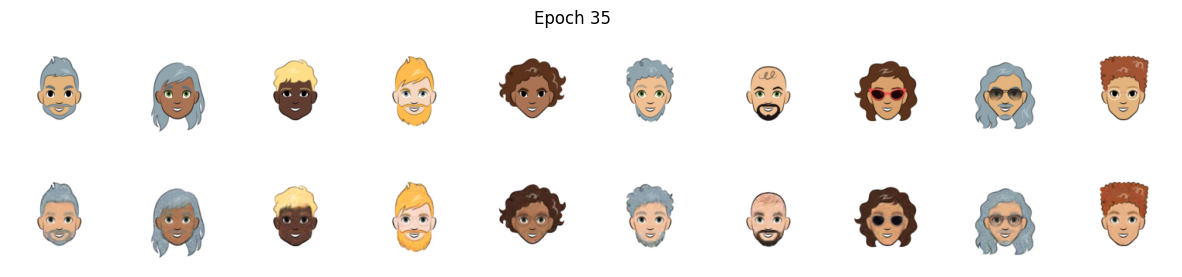

Training complete!


In [ ]:
# Hyperparameters
latent_dim = 15
lr = 5e-4
num_epochs = 35
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Model, optimizer
model = ConvVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


# Load checkpoint if available
checkpoint_path = '/content/vae_checkpoint (1).pth'
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Loaded checkpoint from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No checkpoint found, starting training from scratch")

# Training loop
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(cartoon_loader):
        data = data.to(device)
        data = data[:,:3,:,:]

        optimizer.zero_grad()
        x_recon, mu, logvar = model(data)
        #print(x_recon)
        loss = vae_loss(data, x_recon, mu, logvar)
        train_loss += loss.item()
        loss.backward()

        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(cartoon_loader.dataset)}')

    # Plot images
    model.eval()
    with torch.no_grad():
        sample_data = next(iter(cartoon_loader))
        sample_data = data[:,:3,:,:]
        sample_data = sample_data.to(device)#.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        recon_data, _, _ = model(sample_data)
        plot_images(sample_data, recon_data, epoch + 1)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)



print("Training complete!")

In [ ]:
# Hyperparameters
latent_dim = 15
lr = 5e-4
num_epochs = 35
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Model, optimizer
model = ConvVAE(latent_dim).to(device)



# Image Generation

In [ ]:
# Load the checkpoint
checkpoint = torch.load('/content/vae_checkpoint (1).pth')

# Extract the model state dictionary
model_state_dict = checkpoint['model_state_dict']

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

model.eval()

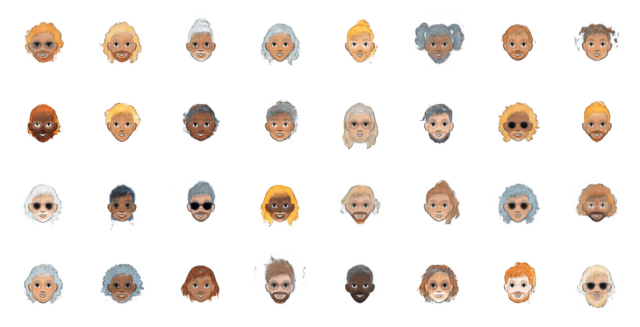

In [ ]:
# Generate images from the latent space
with torch.no_grad():
    # Sample from a standard normal distribution
    z = torch.randn(32, 15).to(device)
    generated_images = model.decoder(z)

# Reshape generated images and visualize
generated_images = generated_images.view(-1, 3, 128, 128)

import matplotlib.pyplot as plt

def show_images(images, nrow=4, ncol=8):
    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol, nrow))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].detach().cpu().numpy().transpose(1,2,0))
        ax.axis('off')
    plt.show()

show_images(generated_images)